In [39]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [40]:
%reload_ext autoreload
%autoreload 2

In [41]:
import copy
import torch
import torch.nn as nn
import torch_geometric.transforms as T
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, PairNorm, MessagePassing
from torch_geometric.utils import add_self_loops, degree, dropout_edge
from tqdm.auto import tqdm
from funcs import *
from models import *

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device), 
    T.RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False),
])
dataset = Planetoid(root='CORA/', name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]

cuda


In [44]:
print(train_data)
print(val_data)
print(test_data)

Data(x=[2708, 1433], edge_index=[2, 8448], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[4224], edge_label_index=[2, 4224])
Data(x=[2708, 1433], edge_index=[2, 8448], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])


In [51]:
train_losses, train_aucs, valid_losses, valid_aucs = train_valid_link(
    GCN4LINK(in_channels=dataset.num_features, n_layers=2, pair_norm=False, activation="relu", add_self_loops=True, drop_edge=0.2),
    train_data, val_data, n_epochs=200, verbose=True)

epcoh [10], train loss: [0.6459], train auc: [0.7667]
epcoh [10], valid loss: [0.6606], valid auc: [0.6832]
epcoh [20], train loss: [0.5504], train auc: [0.8661]
epcoh [20], valid loss: [0.5683], valid auc: [0.8185]
epcoh [30], train loss: [0.5071], train auc: [0.9136]
epcoh [30], valid loss: [0.5386], valid auc: [0.8618]
epcoh [40], train loss: [0.4902], train auc: [0.9341]
epcoh [40], valid loss: [0.5237], valid auc: [0.8783]
epcoh [50], train loss: [0.4758], train auc: [0.9470]
epcoh [50], valid loss: [0.5112], valid auc: [0.8907]
epcoh [60], train loss: [0.4666], train auc: [0.9579]
epcoh [60], valid loss: [0.5069], valid auc: [0.8989]
epcoh [70], train loss: [0.4473], train auc: [0.9656]
epcoh [70], valid loss: [0.4972], valid auc: [0.9079]
epcoh [80], train loss: [0.4481], train auc: [0.9688]
epcoh [80], valid loss: [0.4907], valid auc: [0.9139]
epcoh [90], train loss: [0.4462], train auc: [0.9706]
epcoh [90], valid loss: [0.4938], valid auc: [0.9132]
epcoh [100], train loss: [0.

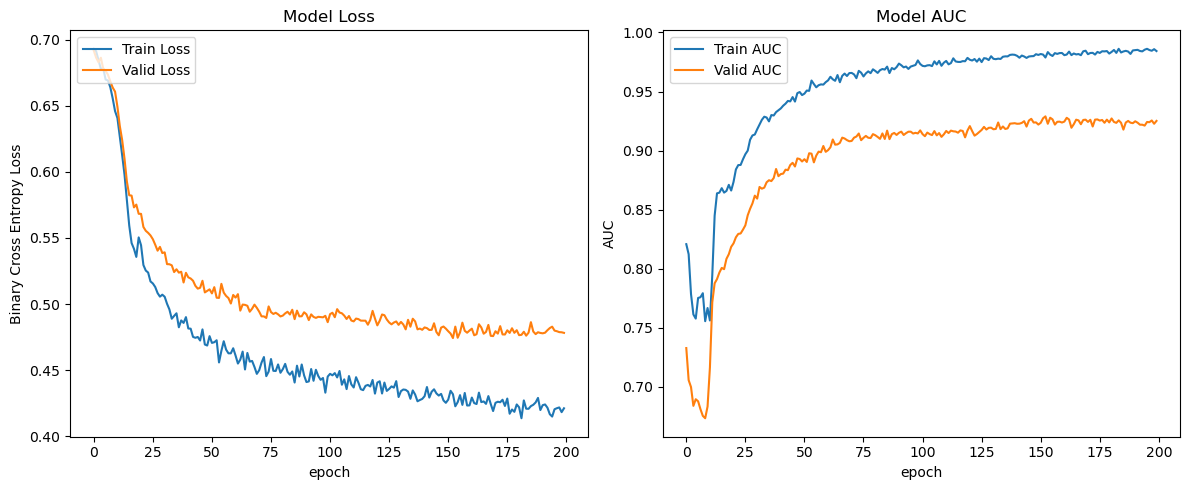

In [52]:
show_process_link(train_losses, train_aucs, valid_losses, valid_aucs)

In [48]:
# from torch_geometric.utils import negative_sampling
# from sklearn.metrics import roc_auc_score

# class Net(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super().__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, out_channels)

#     def encode(self, x, edge_index):
#         x = self.conv1(x, edge_index).relu()
#         return self.conv2(x, edge_index)

#     def decode(self, z, edge_label_index):
#         return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

#     def decode_all(self, z):
#         prob_adj = z @ z.t()
#         return (prob_adj > 0).nonzero(as_tuple=False).t()


# # model = GCN4LINK(in_channels=dataset.num_features, add_self_loops=True).to(device)
# model = Net(dataset.num_features, 128, 64).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.BCEWithLogitsLoss()


# def train():
#     model.train()
#     optimizer.zero_grad()
#     z = model.encode(train_data.x, train_data.edge_index)

#     # We perform a new round of negative sampling for every training epoch:
#     neg_edge_index = negative_sampling(
#         edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
#         num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

#     edge_label_index = torch.cat(
#         [train_data.edge_label_index, neg_edge_index],
#         dim=-1,
#     )
#     edge_label = torch.cat([
#         train_data.edge_label,
#         train_data.edge_label.new_zeros(neg_edge_index.size(1))
#     ], dim=0)

#     out = model.decode(z, edge_label_index).view(-1)
#     loss = criterion(out, edge_label)
#     loss.backward()
#     optimizer.step()
#     return loss


# @torch.no_grad()
# def test(data):
#     model.eval()
#     z = model.encode(data.x, data.edge_index)
#     out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
#     return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


# best_val_auc = final_test_auc = 0
# for epoch in range(1, 101):
#     loss = train()
#     val_auc = test(val_data)
#     test_auc = test(test_data)
#     if val_auc > best_val_auc:
#         best_val_auc = val_auc
#         final_test_auc = test_auc
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
#           f'Test: {test_auc:.4f}')

# print(f'Final Test: {final_test_auc:.4f}')

# z = model.encode(test_data.x, test_data.edge_index)
# final_edge_index = model.decode_all(z)
# final_edge_index1 = model.decode(z, test_data.edge_label_index).view(-1)

In [49]:
loops = [True, False]
layers = [1, 2, 3, 4, 5]
drop_edges = [0, 0.1, 0.2, 0.3, 0.5]
pair_norms = [True, False]
activations = ["relu", "leaky_relu", "tanh", "sigmoid"]

best_loop = True
best_layer = 2
best_drop_edge = 0.2
best_pair_norm = False
best_activation = "tanh"
best_auc = 0

for loop in loops:
    for layer in layers:
        for drop_edge in drop_edges:
            for pair_norm in pair_norms:
                for activation in activations:
                    print("loop: {}, layer: {}, drop_edge: {}, pair_norm: {}, activation: {}".format(loop, layer, drop_edge, pair_norm, activation))
                    train_losses, train_aucs, valid_losses, valid_aucs = train_valid_link(
                        GCN4LINK(in_channels=dataset.num_features, n_layers= layer, 
                            pair_norm=pair_norm, activation=activation, 
                            add_self_loops=loop, drop_edge=drop_edge),
                        train_data, val_data, n_epochs=100, verbose=False)
                    auc = sum(valid_aucs[-50:]) / 50
                    if auc > best_auc:
                        best_auc =  auc
                        best_loop = loop
                        best_layer = layer
                        best_drop_edge = drop_edge
                        best_pair_norm = pair_norm
                        best_activation = activation

loop: True, layer: 1, drop_edge: 0, pair_norm: True, activation: relu
epcoh [100], train loss: [0.4734], train auc: [0.9889]
epcoh [100], valid loss: [0.5451], valid auc: [0.9105]
loop: True, layer: 1, drop_edge: 0, pair_norm: True, activation: leaky_relu
epcoh [100], train loss: [0.4729], train auc: [0.9884]
epcoh [100], valid loss: [0.5447], valid auc: [0.9056]
loop: True, layer: 1, drop_edge: 0, pair_norm: True, activation: tanh
epcoh [100], train loss: [0.4746], train auc: [0.9878]
epcoh [100], valid loss: [0.5432], valid auc: [0.9120]
loop: True, layer: 1, drop_edge: 0, pair_norm: True, activation: sigmoid
epcoh [100], train loss: [0.4731], train auc: [0.9897]
epcoh [100], valid loss: [0.5434], valid auc: [0.9165]
loop: True, layer: 1, drop_edge: 0, pair_norm: False, activation: relu
epcoh [100], train loss: [0.4584], train auc: [0.9660]
epcoh [100], valid loss: [0.5036], valid auc: [0.9205]
loop: True, layer: 1, drop_edge: 0, pair_norm: False, activation: leaky_relu
epcoh [100], 

In [56]:
print("auc: {}, loop: {}, layer: {}, drop_edge: {}, pair_norm: {}, activation: {}"
      .format(best_auc, best_loop, best_layer, best_drop_edge, best_pair_norm, best_activation))

acc: 0.9260703419520467, loop: True, layer: 2, drop_edge: 0.1, pair_norm: False, activation: tanh


In [51]:
train_losses, train_aucs, valid_losses, valid_aucs = train_valid_link(
    GCN4LINK(in_channels=dataset.num_features, n_layers=best_layer, pair_norm=best_pair_norm,
        activation=best_activation, add_self_loops=best_loop, drop_edge=best_drop_edge),
    train_data, val_data, n_epochs=200, verbose=True)

epcoh [10], train loss: [0.6148], train auc: [0.8366]
epcoh [10], valid loss: [0.6152], valid auc: [0.7918]
epcoh [20], train loss: [0.5015], train auc: [0.9145]
epcoh [20], valid loss: [0.5385], valid auc: [0.8720]
epcoh [30], train loss: [0.4767], train auc: [0.9433]
epcoh [30], valid loss: [0.5209], valid auc: [0.8934]
epcoh [40], train loss: [0.4684], train auc: [0.9559]
epcoh [40], valid loss: [0.5035], valid auc: [0.9089]
epcoh [50], train loss: [0.4480], train auc: [0.9691]
epcoh [50], valid loss: [0.5007], valid auc: [0.9105]
epcoh [60], train loss: [0.4396], train auc: [0.9765]
epcoh [60], valid loss: [0.4962], valid auc: [0.9160]
epcoh [70], train loss: [0.4318], train auc: [0.9784]
epcoh [70], valid loss: [0.4839], valid auc: [0.9238]
epcoh [80], train loss: [0.4360], train auc: [0.9806]
epcoh [80], valid loss: [0.4923], valid auc: [0.9176]
epcoh [90], train loss: [0.4257], train auc: [0.9840]
epcoh [90], valid loss: [0.4913], valid auc: [0.9165]
epcoh [100], train loss: [0.

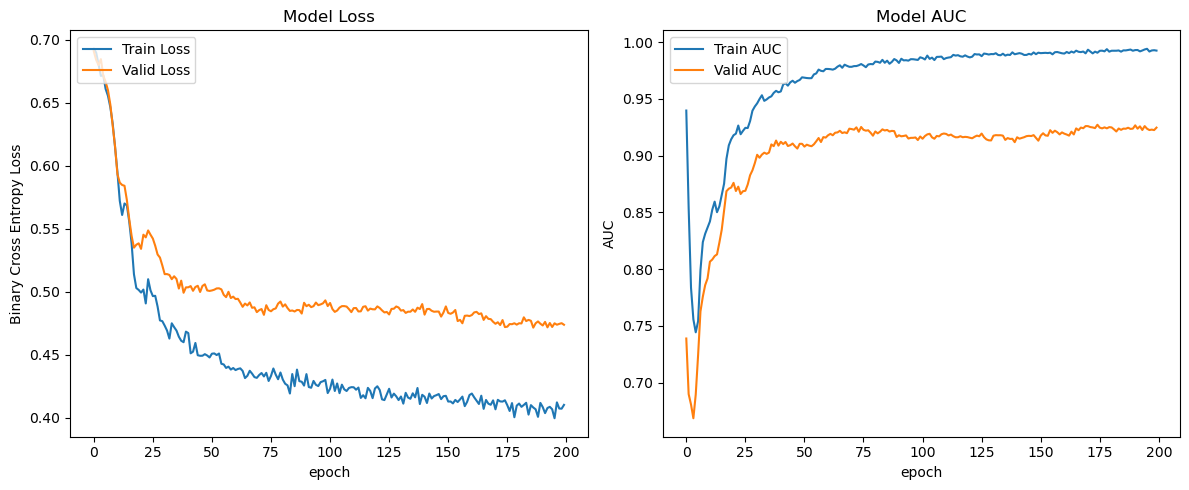

In [52]:
show_process_link(train_losses, train_aucs, valid_losses, valid_aucs)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN4LINK(in_channels=dataset.num_features, n_layers=best_layer, pair_norm=best_pair_norm, 
            activation=best_activation, add_self_loops=best_loop, drop_edge=best_drop_edge).to(device)
train_data1 = train_data.to(device)
test_data1 = test_data.to(device)
n_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

train_losses = []
train_aucs = []

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data1.x, train_data1.edge_index)
    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(edge_index=train_data1.edge_index, num_nodes=train_data1.num_nodes,
        num_neg_samples=train_data1.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data1.edge_label_index, neg_edge_index], dim=-1,)
    edge_label = torch.cat([train_data1.edge_label, train_data1.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    pred = model.decode(z, edge_label_index).view(-1)
    train_loss = criterion(pred, edge_label)
    if train_loss.isnan():
        continue
    train_loss.backward()
    optimizer.step()
    pred_label = pred.sigmoid()
    train_auc = roc_auc_score(edge_label.cpu().detach().numpy(), pred_label.detach().cpu().numpy())
    if epoch % 10 == 0:
        print("epcoh [%d], train loss: [%.4f], train auc: [%.4f]" %(epoch, train_loss, train_auc))

    train_losses.append(train_loss.item())
    train_aucs.append(train_auc)

model.eval()
with torch.no_grad():
    z = model.encode(val_data.x, val_data.edge_index)
    pred = model.decode(z, val_data.edge_label_index).view(-1)
    test_loss = criterion(pred, val_data.edge_label).item()
    pred_label = pred.sigmoid()
    test_auc = roc_auc_score(val_data.edge_label.cpu().numpy(), pred_label.cpu().numpy())
    print("\ntest loss: [%.4f], test auc: [%.4f]" %(test_loss, test_auc))

epcoh [10], train loss: [0.6133], train auc: [0.7967]
epcoh [20], train loss: [0.5066], train auc: [0.9130]
epcoh [30], train loss: [0.4693], train auc: [0.9443]
epcoh [40], train loss: [0.4601], train auc: [0.9586]
epcoh [50], train loss: [0.4444], train auc: [0.9702]
epcoh [60], train loss: [0.4486], train auc: [0.9705]
epcoh [70], train loss: [0.4313], train auc: [0.9786]
epcoh [80], train loss: [0.4322], train auc: [0.9816]
epcoh [90], train loss: [0.4321], train auc: [0.9815]
epcoh [100], train loss: [0.4319], train auc: [0.9832]
epcoh [110], train loss: [0.4299], train auc: [0.9840]
epcoh [120], train loss: [0.4230], train auc: [0.9867]
epcoh [130], train loss: [0.4187], train auc: [0.9874]
epcoh [140], train loss: [0.4212], train auc: [0.9887]
epcoh [150], train loss: [0.4143], train auc: [0.9901]
epcoh [160], train loss: [0.4098], train auc: [0.9912]
epcoh [170], train loss: [0.4150], train auc: [0.9910]
epcoh [180], train loss: [0.4142], train auc: [0.9918]
epcoh [190], train 

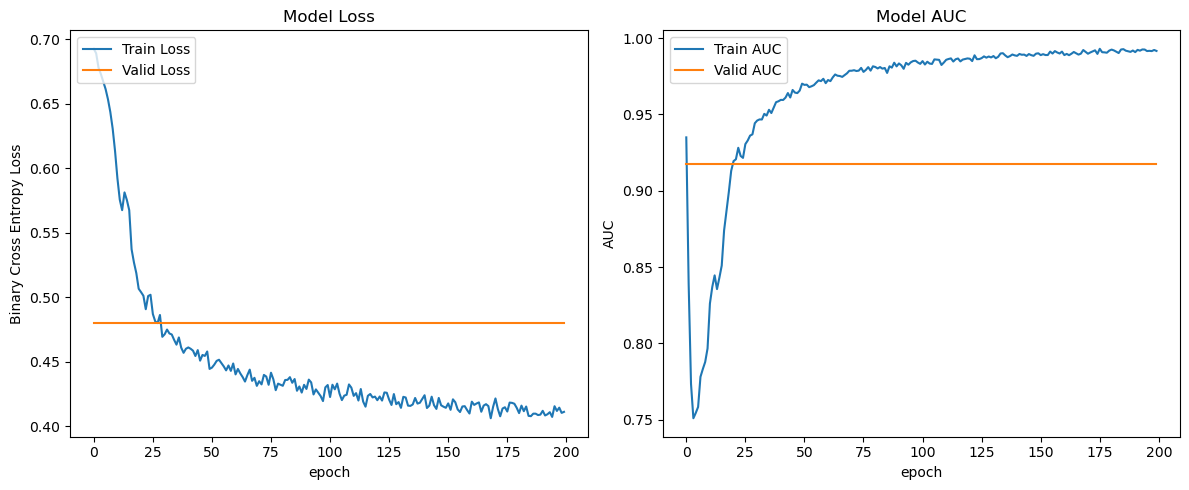

In [54]:
test_losses = [test_loss for _ in range(n_epochs)]
test_aucs = [test_auc for _ in range(n_epochs)]
show_process_link(train_losses, train_aucs, test_losses, test_aucs)